In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
from jax import grad, vmap, jit, jacfwd, jacrev, value_and_grad
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.random as random
from jax.lax import cond, scan
import jax.example_libraries.optimizers as optimizers
key = random.PRNGKey(2022)

from utils_node import init_params_damage, init_params_damage_simple
from utils_node import RK_forward_pass_nobias as NODE_nobias, RK_forward_pass as NODE

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import pickle


from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5, Dopri8, Heun, Tsit5, Kvaerno3, Kvaerno4, Kvaerno5
from diffrax import PIDController

mysolver = Heun

In [2]:
specimen = 'PA_Belly_SubQ1'
# data = pd.read_csv('data/SubQ/DamageData/' + specimen + '/1.csv')

lmbx_u_gt = []
sgmx_u_gt = []
for i in range(4):
    fname = 'data/SubQ/DamageData/' + specimen + '/' + str(i+1) + '.csv'
    data = np.loadtxt(fname, delimiter=',')
    lmbx_u_gt.append(data[:,0])
    sgmx_u_gt.append(data[:,1])
lmbx_u_gt = np.array(lmbx_u_gt)
sgmx_u_gt = np.array(sgmx_u_gt)

n_cycles = len(lmbx_u_gt)

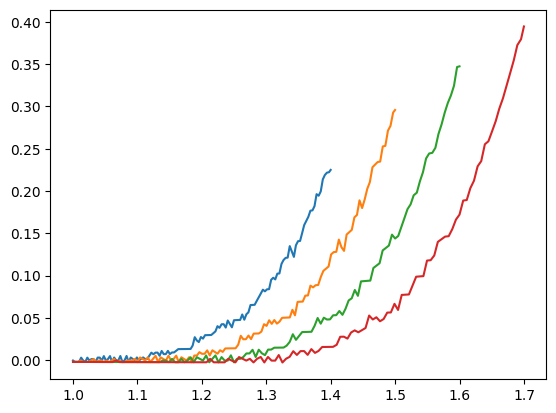

In [3]:
for i in range(4):
    plt.plot(lmbx_u_gt[i], sgmx_u_gt[i])

In [4]:
#Psi functions
def Psi1_fn(params, I1):
    params, bias = params
    return NODE_nobias(I1-3, params) + jnp.exp(bias)
def Psi2_fn(params, I2):
    params, bias = params
    return NODE_nobias(I2-3, params) + jnp.exp(bias)
def Psiv_fn(params, Iv):
    params, theta = params
    Psiv = NODE_nobias(Iv-1, params)
    return jnp.maximum(Psiv, 0.0)
def Psiw_fn(params, Iw):
    params, theta = params
    Psiw = NODE_nobias(Iw-1, params)
    return jnp.maximum(Psiw, 0.0)
Psi_fns = (Psi1_fn, Psi2_fn, Psiv_fn, Psiw_fn)

def f(d, params):
    return 1.0-d
f_vmap = vmap(f, in_axes=(0, None))
def G(tau, params):
    tau = tau/500.0 #divide by 500 for normalization
    params, a = params
    # tau = jnp.log(tau)/10.0 # normalization
    # return NODE_nobias(tau, params)
    return jnp.tanh(jnp.exp(a)*NODE_nobias(tau, params))
G_vmap = vmap(G, in_axes=(0, None))

In [5]:
# These functions are needed for predictions under realistic loading cases
def eval_Cauchy_singlevar(lmbx, lmby, d, params):
    params_Psi1, params_G = params

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    Cinv = jnp.linalg.inv(C)

    I1 = C[0,0] + C[1,1] + C[2,2]

    f1 = jnp.clip(1.0-d, a_min=0.0, a_max=1.0)
    Psi1 = jnp.exp(Psi1_fn(params_Psi1, I1))

    p = -C[2,2]*(2*Psi1)
    S = p*Cinv + 2*Psi1*jnp.eye(3) # do (1-d)* the usual S
    S = f1*S

    sgm = F @ (S @ F.T)
    return sgm
eval_Cauchy_vmap = vmap(eval_Cauchy_singlevar, in_axes=(0,0,0,None), out_axes = 0)
eval_Cauchy_vmap2 = vmap(eval_Cauchy_singlevar, in_axes=(0,0,None,None), out_axes = 0)

In [6]:
@partial(jit, static_argnums=(3,))
def ddot_singlevar(params_G, y, taudot, ddot_fn):
    """
    Difference between this function and, say, ddot_vahid: 
    1. This function checks for damage criterion.
    2. This function returns both ddot and rdot

    Differences from the ddot_fn in the other notebooks:
    1. It works with only 1 damage function (Psi_I1)
    2. It assumes f=1-d
    """
    d, r, tau = y

    #check if g<0
    g = G(tau, params_G) - G(r, params_G)
    def true_fun(): #What to return for rdot & ddot if g<0
        return 0.0, 0.0, taudot
    def false_fun():
        ddot = ddot_fn(params_G, tau, taudot)
        rdot = taudot
        return ddot, rdot, taudot
    ydot = cond(g<0, true_fun, false_fun)
    return jnp.stack(ydot)

def Psi1_uniaxial(t, params_Psi, lmb_dot):
    lmbx = 1.0 + lmb_dot*t
    I1 = lmbx**2 + 2.0/lmbx # = lmbx**2 + lmby**2 + lmbz**2
    return Psi1_fn(params_Psi, I1)

def I1_fn(t, lmb_dot):
    lmbx = 1.0 + lmb_dot*t
    return lmbx**2 + 2.0/lmbx # = lmbx**2 + lmby**2 + lmbz**2

@partial(jit, static_argnums=(3,))
def integrate_d_uniax(params, lmb_max, y0, ddot_fn, saveat):
    params_Psi, params_G = params
    t_peak = 1.0
    lmb_dot = (lmb_max-1.0)/t_peak
    def yprime(t, y, args=None):
        I1, I1dot = value_and_grad(I1_fn)(t, lmb_dot)
        taudot = jnp.exp(Psi1_fn(params_Psi, I1))*I1dot
        return ddot_singlevar(params_G, y, taudot, ddot_fn)
    
    solution = diffeqsolve(terms=ODETerm(yprime), 
                           solver=Dopri5(), 
                           t0=0.0, 
                           t1=1.0, 
                           dt0=1.e-4, 
                           y0=y0, 
                           saveat=SaveAt(ts=saveat), 
                           max_steps=1048576)
    return solution.ys

# @partial(jit, static_argnums=(2,3,))
def repeat_uniax(params, lmb_max_list, ddot_fn, saveat):
    y0 = jnp.array([0.0,0.0,0.0]) # y0 = (d0, r0, tau0)

    # t and lmb are dummy vars, but it is convenient to return them from here
    t_list   = []
    lmb_list = []
    d_list   = []
    t0 = 0.0
    for i in range(len(lmb_max_list)):
        lmb_max = lmb_max_list[i]

        y = integrate_d_uniax(params, lmb_max, y0, ddot_fn, saveat)
        d_load   = y[:,0] #y consists of [r, d, tau], but we don't need to return r
        t0+= 1.0
        #Unloading curves
        t_unload   = t0 + saveat
        t0+= 1.0
        y0 = y[-1]
        y0 = y0.at[2].set(jnp.float64(0.0))

        t_list.append(t_unload)
        d_list.append(d_load)

    return jnp.array(t_list), jnp.array(lmb_list), jnp.clip(jnp.array(d_list), a_min=0.0, a_max=1.0)

@jit
def ddot_vahid(params_G, tau, taudot):
    ddot = taudot*grad(G)(tau, params_G)
    return ddot
ddot_vahid_vmap = vmap(ddot_vahid, in_axes=(None, 0, 0))

In [7]:
params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
lmbx_max_list = [np.max(x) for x in lmbx_u_gt]
saveat = jnp.linspace(0,1.0)
t, lmbx, d_pr = repeat_uniax(params, lmbx_max_list, ddot_vahid,saveat)

In [8]:
@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state):
    params = get_params(opt_state)
    g = grad(loss)(params)
    return opt_update(i, g, opt_state)

def train(loss, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None):
    train_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        opt_state = step(loss, it, get_params, opt_update, opt_state)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, metrics


lmbx_max_list = [np.max(x) for x in lmbx_u_gt]
def loss(params):
    saveat = jnp.linspace(0,1,2)
    t, lmbx, d_pr = repeat_uniax(params, lmbx_max_list, ddot_vahid, saveat)
    loss = []
    for i in range(5):
        di = d_pr[i]
        lmbx = lmbx_u_gt[i]
        lmby = 1.0/jnp.sqrt(lmbx)
        sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)[:,0,0]
        loss.append(jnp.mean((sgmx_u_gt[i]-sgmx_pr)**2))

    return jnp.mean(jnp.array(loss))

### Strategy 1: Train directly against stress data (doesn't work well)

In [8]:
params = init_params_damage_simple(key, Psi_layers=[1,3,3,3,1], G_layers=[1,5,5,5,1])
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

params, train_loss, _ = train(loss, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=1000)

it 1000, train loss = 2.647062e-01
it 2000, train loss = 2.289590e-01
it 3000, train loss = 1.824340e-01
it 4000, train loss = 1.669759e-01
it 5000, train loss = 1.608701e-01
it 6000, train loss = 1.576964e-01
it 7000, train loss = 1.558783e-01
it 8000, train loss = 1.546284e-01
it 9000, train loss = 1.542735e-01
it 10000, train loss = 1.535645e-01
it 11000, train loss = 1.525832e-01
it 12000, train loss = 1.482910e-01
it 13000, train loss = 1.293395e-01
it 14000, train loss = 1.267223e-01
it 15000, train loss = 1.261115e-01
it 16000, train loss = 1.256101e-01
it 17000, train loss = 1.251266e-01
it 18000, train loss = 1.247665e-01
it 19000, train loss = 1.245024e-01
it 20000, train loss = 1.242981e-01


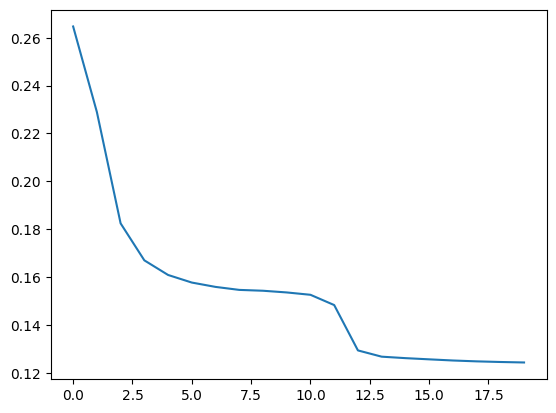

In [9]:
plt.plot(train_loss)

[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

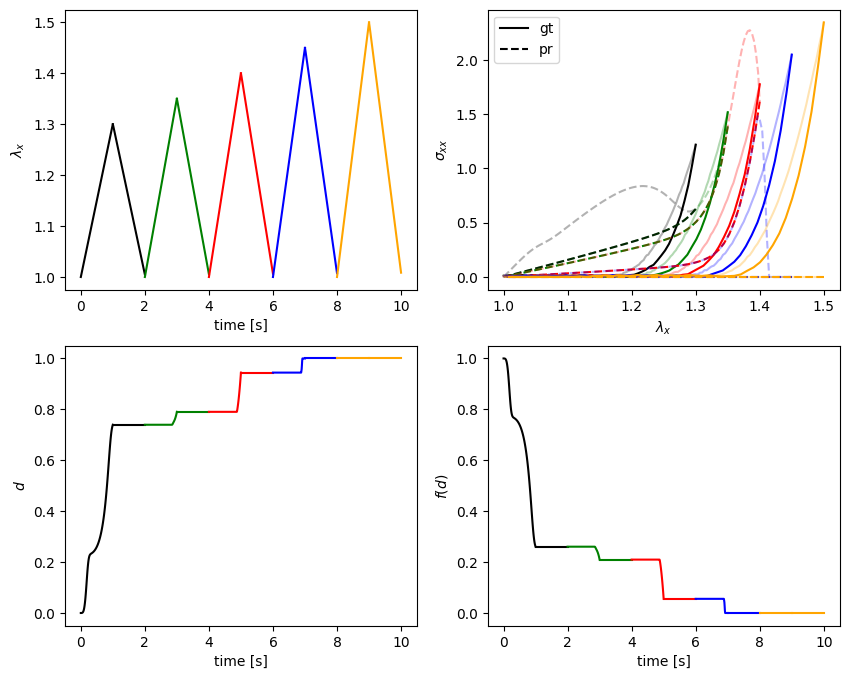

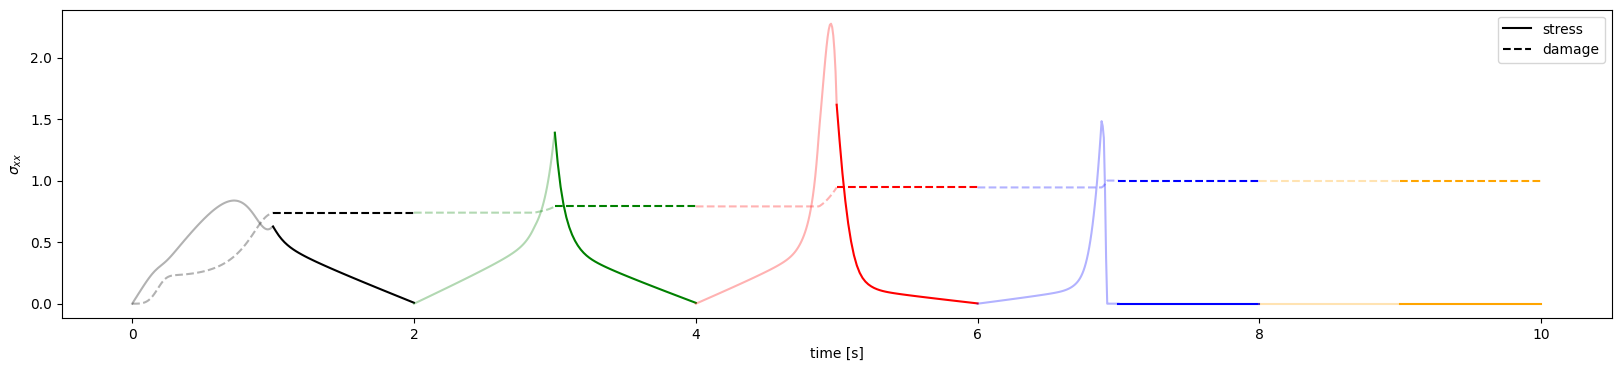

In [10]:
f_params = params[1]
saveat = np.linspace(0,1.0,lmbx_l_gt.shape[1])
t, _, d = repeat_uniax(params, lmbx_max_list, ddot_vahid, saveat)
d = np.array(d)
d = np.clip(d, a_min=0.0, a_max=1.0)
fig, ax = plt.subplots(2,2,figsize=(10,8))
fig, ax2 = plt.subplots(figsize=(20,4))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']

t0 = 0.0
for i in range(n_cycles):
    # Loading
    col = cols[i]
    di = d[i]
    lmbx_l = lmbx_l_gt[i]
    lmby_l = 1.0/np.sqrt(lmbx_l)
    time_l = t0 + np.linspace(0,1,lmbx_l.shape[0])
    sgmx_l = sgmx_l_gt[i]
    t0 += 1.0

    sgmx_l_pr = eval_Cauchy_vmap(lmbx_l, lmby_l, di, params)[:,0,0]

    ax[0,0].plot(time_l, lmbx_l, col)
    ax[0,1].plot(lmbx_l, sgmx_l_pr, col, linestyle='dashed', alpha=0.3)
    ax[0,1].plot(lmbx_l, sgmx_l, col, linestyle='solid', alpha=0.3)
    ax[1,0].plot(time_l, di, col)
    ax[1,1].plot(time_l, f_vmap(di, f_params), col)

    # ax[0,2].plot(time_l, sgmx_l, col, alpha=0.3)
    ax2.plot(time_l, sgmx_l_pr, col, alpha=0.3)
    ax2.plot(time_l, di, col, linestyle='dashed', alpha=0.3)

    # Unloading
    lmbx_u = np.flip(lmbx_u_gt[i])
    lmby_u = 1.0/np.sqrt(lmbx_u)
    time_u = t0 + np.linspace(0,1,lmbx_u.shape[0])
    t0 += 1
    sgmx_u = np.flip(sgmx_u_gt[i])
    sgmx_u_pr = eval_Cauchy_vmap2(lmbx_u, lmby_u, di[-1], params)[:,0,0]

    ax[0,0].plot(time_u, lmbx_u, col)
    ax[0,1].plot(lmbx_u, sgmx_u_pr, col, linestyle='dashed')
    ax[0,1].plot(lmbx_u, sgmx_u, col, linestyle='solid')
    ax[1,0].plot(time_u, di[-1]*np.ones_like(time_u), col)
    ax[1,1].plot(time_u, f_vmap(di[-1]*np.ones_like(time_u), f_params), col)

    ax2.plot(time_u, sgmx_u_pr, col)
    ax2.plot(time_u, di[-1]*np.ones_like(time_u), col, linestyle='dashed')

    sgmx_l = sgmx_l_gt[i]

ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')

legend_elements = [Line2D([0], [0], color='k', linestyle= '-', label='gt'),
                   Line2D([0], [0], color='k', linestyle='--', label='pr')]
ax[0,1].legend(handles=legend_elements)
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

legend_elements = [Line2D([0], [0], color='k', linestyle= '-', label='stress'),
                   Line2D([0], [0], color='k', linestyle='--', label='damage')]
ax2.legend(handles=legend_elements)
ax2.set(xlabel='time [s]', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

### Strategy 2: Train just Psi_params + 5 damage parameters

In [9]:
def loss_Psi(params):
    d, params_Psi = params
    loss = []
    for i in range(len(lmbx_u_gt)):
        lmbx = lmbx_u_gt[i]
        lmby = 1.0/jnp.sqrt(lmbx)
        sgmx = sgmx_u_gt[i]
        di = jax.nn.sigmoid(d[i])
        sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di, (params_Psi, None))[:,0,0]
        loss.append(jnp.mean((sgmx-sgmx_pr)**2))
    return jnp.mean(jnp.array(loss))


params = init_params_damage_simple(key, Psi_layers=[1,3,3,3,1], G_layers=[1,5,5,5,1])
params_Psi = params[0]
d = np.linspace(0,0.8,n_cycles)
params = (d, params_Psi)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

params, train_loss, _ = train(loss_Psi, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)
# min so far: 2.524991e-04: 5.e-4, 200k, Psi_layers=[1,3,3,3,1]

it 10000, train loss = 3.680298e-03
it 20000, train loss = 8.767564e-05
it 30000, train loss = 2.500802e-05
it 40000, train loss = 2.453413e-05
it 50000, train loss = 2.446968e-05
it 60000, train loss = 2.442112e-05
it 70000, train loss = 2.435700e-05
it 80000, train loss = 2.430894e-05
it 90000, train loss = 2.427717e-05
it 100000, train loss = 2.425817e-05


d =  [0.99629108 0.99826984 0.99919426 0.99960915]


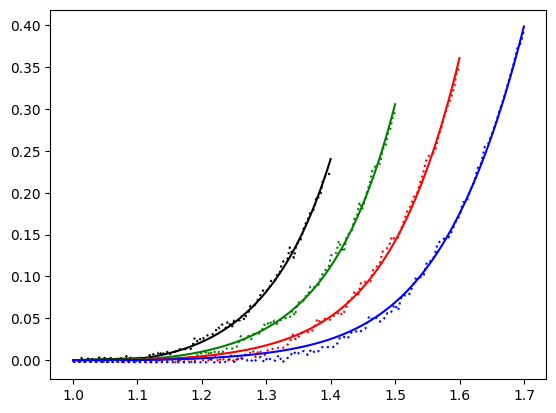

In [10]:
d_gt, params_Psi = params
d_gt = jax.nn.sigmoid(d_gt)
print('d = ', d_gt)
fig, ax = plt.subplots()
cols = ['black', 'green', 'red', 'blue', 'orange']

for i, di in enumerate(d_gt):
    lmbx = lmbx_u_gt[i]
    lmby = 1.0/jnp.sqrt(lmbx)
    sgmx = sgmx_u_gt[i]
    col = cols[i]
    sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di, (params_Psi, None))[:,0,0]
    ax.plot(lmbx, sgmx_pr, col)
    ax.plot(lmbx, sgmx, col, linestyle=':')

Train params_G with these d values

In [11]:
# Task: integrate ddot_vahid_vmap from 0 to whatever Psi0 (tau) reaches in the first curve, and compare the value of d at the peak
saveat = [3.0]
for lmbx in lmbx_max_list:
    # get peak tau for each curve. To do this, we need to integrate Psi1_fn (i.e., dPsi/dI1)
    I1 = lmbx**2 + 2.0/lmbx
    saveat.append(I1)
saveat = jnp.array(saveat)
def yprime(I1, y, args=None): #The independent variable here is I1, not t.
    return jnp.exp(Psi1_fn(params_Psi, I1))

solution = diffeqsolve(terms=ODETerm(yprime), 
                       solver=Kvaerno5(), 
                       t0=saveat[0], 
                       t1=saveat[-1], 
                       dt0=1.e-5, 
                       y0=jnp.array([0.0]), 
                       saveat=SaveAt(ts=saveat),
                       max_steps=1048576,
                       stepsize_controller=PIDController(rtol=1e-9, atol=1e-9))
tau_gt = solution.ys.flatten()


def loss_d(params_G):
    d_pr = []
    for taui_gt in tau_gt[1:]:
        d_pr.append(G(taui_gt, params_G))
    d_pr = jnp.array(d_pr)
    return jnp.mean((d_gt-d_pr)**2)


params = init_params_damage_simple(key, Psi_layers=[1,3,3,3,1], G_layers=[1,5,5,5,1])
params_G = params[1]
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params_G)

params_G, train_loss, _ = train(loss_d, get_params, opt_update, opt_state, key, nIter = 15000000, print_freq=10000)
#last run: 4.401112e-10 with 5.e-5, [1,5,5,5,1], 3m

it 10000, train loss = 1.760981e-05
it 20000, train loss = 5.268672e-08
it 30000, train loss = 4.757128e-10
it 40000, train loss = 4.703923e-10
it 50000, train loss = 4.608153e-10
it 60000, train loss = 4.505261e-10
it 70000, train loss = 4.395690e-10
it 80000, train loss = 4.279131e-10
it 90000, train loss = 4.155335e-10
it 100000, train loss = 4.024150e-10
it 110000, train loss = 3.885557e-10
it 120000, train loss = 3.739729e-10
it 130000, train loss = 3.587082e-10
it 140000, train loss = 3.428349e-10
it 150000, train loss = 3.264641e-10
it 160000, train loss = 3.097508e-10
it 170000, train loss = 2.928969e-10
it 180000, train loss = 2.761499e-10
it 190000, train loss = 2.597955e-10
it 200000, train loss = 2.441414e-10
it 210000, train loss = 2.294936e-10
it 220000, train loss = 2.161268e-10
it 230000, train loss = 2.042537e-10
it 240000, train loss = 1.940005e-10
it 250000, train loss = 1.853945e-10
it 260000, train loss = 1.783673e-10
it 270000, train loss = 1.727727e-10
it 280000,

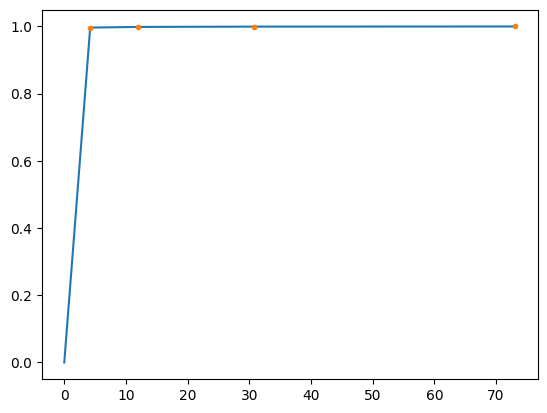

In [31]:
d_pr = []
for taui_gt in tau_gt:
    d_pr.append(G(taui_gt, params_G))
d_pr = jnp.array(d_pr)

plt.plot(tau_gt, d_pr)

temp = np.hstack([np.zeros(1), d_gt])
plt.plot(tau_gt[1:], d_gt, '.')

In [34]:
d_pr = []
for taui_gt in tau_gt[1:]:
    d_pr.append(G(taui_gt, params_G) - G(tau_gt[0], params_G))
d_pr = jnp.array(d_pr)

gt:  [0.99629108 0.99826984 0.99919426 0.99960915]
pr:  [0.99629066 0.99827252 0.99918849 0.9996133 ]


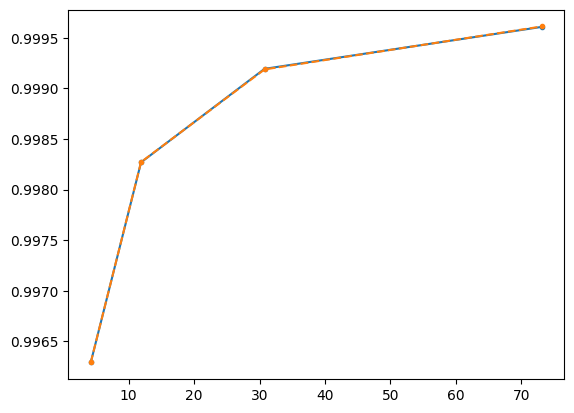

In [35]:
print('gt: ', d_gt)
print('pr: ', d_pr.flatten())

fig, ax = plt.subplots()
ax.plot(tau_gt[1:], d_gt, '.-')
ax.plot(tau_gt[1:], d_pr, '.--')

In [36]:
def integrate_d(params_G):
    def yprime(tau, d, args=None): # Here the independent variable is tau, the dependent variable is d
        # yprime = dd/dtau = dG/dtau (see ipad notes)
        return grad(G)(tau, params_G)
    
    solution = diffeqsolve(terms=ODETerm(yprime), 
                           solver=mysolver(), 
                           t0=tau_gt[0], 
                           t1=tau_gt[-1], 
                           dt0=0.001, 
                           y0=jnp.array([0.0]), 
                           saveat=SaveAt(ts=tau_gt),
                           max_steps=1048576)
    d_pr = solution.ys[1:]
    return d_pr

In [37]:
d_pr = integrate_d(params_G)
print('gt: ', d_gt)
print('pr: ', d_pr.flatten())

gt:  [0.99629108 0.99826984 0.99919426 0.99960915]
pr:  [2.27118408 2.27316594 2.2740819  2.27450672]


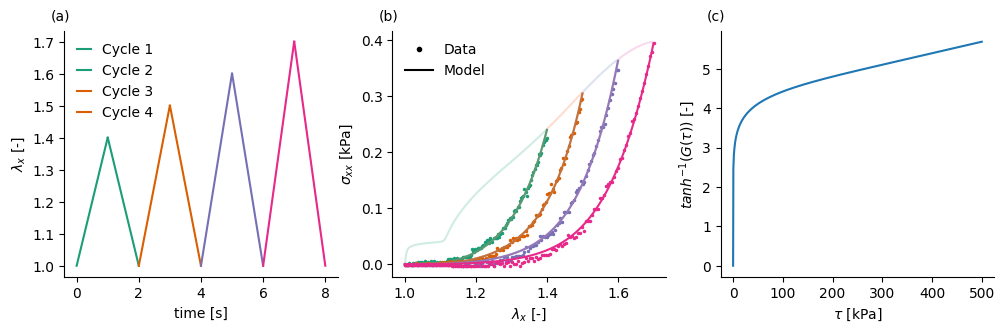

In [38]:
params = (params_Psi, params_G)
f_params = None
saveat = np.linspace(0,1.0,lmbx_u_gt.shape[1])
t, _, d = repeat_uniax(params, lmbx_max_list, ddot_vahid, saveat)
d = np.array(d)
d = np.clip(d, a_min=0.0, a_max=1.0)

resize = 0.8
n_ax = 3
fig, ax = plt.subplots(1,3,figsize=(5*n_ax*resize,4*resize))

cols = ['black', 'green', 'red', 'blue', 'orange']

t0 = 0.0
for i in range(n_cycles):
    # Loading
    col = cols[i]
    di = d[i]
    lmbx_l = lmbx_u_gt[i]
    lmby_l = 1.0/np.sqrt(lmbx_l)
    time_l = t0 + np.linspace(0,1,lmbx_l.shape[0])
    t0 += 1.0

    sgmx_l_pr = eval_Cauchy_vmap(lmbx_l, lmby_l, di, params)[:,0,0]

    ax[0].plot(time_l, lmbx_l, color=plt.cm.Dark2(i))
    ax[1].plot(lmbx_l, sgmx_l_pr, color=plt.cm.Set2(i), alpha=0.3)
    # ax[2].plot(time_l, di, color=plt.cm.Dark2(i))


    # Unloading
    lmbx_u = np.flip(lmbx_u_gt[i])
    lmby_u = 1.0/np.sqrt(lmbx_u)
    time_u = t0 + np.linspace(0,1,lmbx_u.shape[0])
    t0 += 1
    sgmx_u = np.flip(sgmx_u_gt[i])
    sgmx_u_pr = eval_Cauchy_vmap2(lmbx_u, lmby_u, di[-1], params)[:,0,0]

    ax[0].plot(time_u, lmbx_u, color=plt.cm.Dark2(i))
    ax[1].plot(lmbx_u, sgmx_u_pr, color=plt.cm.Dark2(i))
    ax[1].plot(lmbx_u, sgmx_u, color=plt.cm.Dark2(i), marker='.', markersize=3, lw=0)
    # ax[2].plot(time_u, di[-1]*np.ones_like(time_u), color=plt.cm.Dark2(i))



ax[0].set(xlabel='time [s]', ylabel = '$\lambda_x$ [-]')

legend_elements = [Line2D([0], [0], color='k', marker='.', linestyle=None, label='Data', lw=0),
                   Line2D([0], [0], color='k', linestyle='-', label='Model')]
ax[1].legend(handles=legend_elements, frameon=False)
ax[1].set(xlabel='$\lambda_x$ [-]', ylabel='$\sigma_{xx}$ [kPa]')

[a.spines['top'].set_visible(False)  for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
labels='abc'
for label, axi in zip(labels, ax):
    axi.text(-0.05, 1.04, '('+label+')', transform=axi.transAxes)

# ax[2].set(xlabel='time [s]', ylabel='$d$ [-]')

ax[0].legend(['Cycle 1', 'Cycle 2', 'Cycle 3', 'Cycle 4'], frameon=False, handlelength=1, loc='upper left')


x = np.linspace(0,500,1000)
y = vmap(G, in_axes=(0,None))(x, params_G)
y = np.arctanh(y)
ax[2].plot(x,y)
ax[2].set(xlabel='$\\tau$ [kPa]', ylabel='$tanh^{-1}(G(\\tau))$ [-]')


fig.savefig('figs/fig_subq1.pdf', bbox_inches='tight')